## Toxicogenomics Time-Series Data Analytics

brainstorm
一个链接：https://zhuanlan.zhihu.com/p/67832773
不同基因在时间上的表达趋势预测
特征工程：什么基因对表达预测的影响最大
这些基因和什么相关？

一篇PNAS链接：https://www.pnas.org/doi/10.1073/pnas.2025952118

差异分析：比较不同时间点和基因之间的表达差异，以识别与特定生物过程相关的基因。

特征选择：使用特征选择算法识别最相关的基因，以帮助简化模型并提高预测性能，识别重要的基因和趋势

相关性分析：计算基因之间的相关性，以探索基因之间的相互作用和可能的生物学机制。
    基因网络分析：使用基因网络分析工具，通过构建基因网络图谱来识别不同基因之间的相互作用，并探索可能的生物学机制。

    基因富集分析：使用基因富集分析算法，识别与特定生物过程相关的基因，以帮助深入了解生物学过程和机制。
    
    群体聚类：使用聚类算法对基因进行聚类分析，以了解基因表达模式的相似性和差异性，并识别出潜在的生物学意义。


时间序列分析：使用时间序列分析技术，探索不同基因在时间上的变化趋势和相互作用，以识别潜在的生物学意义。

深度学习模型：使用深度学习模型，例如神经网络模型，对基因表达数据进行建模和预测，以提高预测精度和准确性。

统计建模：使用统计建模技术，例如线性回归和逻辑回归等，对基因表达数据进行建模和预测，以探索基因之间的相关性和预测可能的生物学机制。

Brainstorm about the projects
看看这个教授的paper，很多AR相关的：https://xueningzhu.github.io/publications/
先聚类、再在类中ranking、再做VAR分析：https://arxiv.org/pdf/2007.05521.pdf 
1. Time series analysis 
    - to fit and predict multi-variate trend; maybe MCMC?
    - to find the causal relationships between variables; maybe sVAR/Kalman Smoother -> latent variable?

2. Clustering analysis
    - cluster genes to find similar clusters

3. Correlation analysis
    - find the correlation

random thoughts
- shock from outside toxics on certain gene expression? like monetary policy shock

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Prepare and Clean the data 

In [3]:
# load gene library
lib = pd.read_excel("/Users/zijianleowang/Downloads/1000_genes_10_replicates_1_concentrations/Ecoli Lib/e.coli-promoter-library-0222.xls",
                    sheet_name="ALL")
lib = lib.loc[~lib["Gene_Name"].isna(),:][["Gene_Name","Description"]]
lib.columns = ["GeneName","Description"]

# remove duplicated GeneName
lib = lib.drop_duplicates("GeneName")
print(lib.head)

<bound method NDFrame.head of      GeneName                                        Description
0         aer           aerotaxis sensor receptor, flavoprotein 
1        amiC    N-acetylmuramoyl-L-alanine amidase (2nd module)
2        argA  N-alpha-acetylglutamate synthase (amino-acid a...
3        argC  N-acetyl-gamma-glutamylphosphate reductase, NA...
4        argD  acetylornithine transaminase (NAcOATase and Da...
...       ...                                                ...
1924     yafZ                               hypothetical protein
1925     ybjG                                  putative permease
1927     yfbM                                  conserved protein
1928     yoaD                     conserved protein (2nd module)
1930     yebQ                                        unknown CDS

[1809 rows x 2 columns]>


In [36]:
pathin = "/Users/zijianleowang/Downloads/1000_genes_10_replicates_1_concentrations"
tp_path = os.listdir(pathin) # timepoint path
tp_path = sorted([temp for temp in tp_path if (not temp.startswith(".") and temp.endswith(".tsv"))]) # sorted time points file from t0 to t24


for i,tp in enumerate(tp_path): # i shows time point
    dfi = pd.read_csv(os.path.join(pathin,tp),
                sep="\t") # 1760 genes x [GeneName, GeneID, 10 replicates]
    merged_dfi = pd.merge(dfi,lib,on="GeneName",how="inner").sort_values("GeneID") 
    merged_dfi = merged_dfi.reindex(sorted(merged_dfi.columns,reverse=True), axis=1)
    
    
    if i==0: # time point 0
        # save mean
        mean_df = pd.concat([merged_dfi.iloc[:,:3],
                          merged_dfi.iloc[:,3:].mean(axis=1)],axis=1)
        mean_df.columns = mean_df.columns[:-1].tolist() + ["t%i"%i]
        
        # save each replicate
        replicates = [] # init replicates list
        for j in range(merged_dfi.shape[1]-3): # j denotes replicate
            merged_dfij = merged_dfi[["GeneName","GeneID","Description",str(j)]]
            merged_dfij.columns = ["GeneName","GeneID","Description","t%i"%i]
            replicates.append(
                merged_dfij
            )
    else: 
        # save mean
        mean_dfi = pd.concat([merged_dfi.iloc[:,:3],
                          merged_dfi.iloc[:,3:].mean(axis=1)],axis=1)
        mean_dfi.columns = mean_dfi.columns[:-1].tolist() + ["t%i"%i] 
        mean_df = pd.merge(mean_df,mean_dfi,on=["GeneName","GeneID","Description"],how="inner")

        # save each replicate
        for j in range(merged_dfi.shape[1]-3):
            merged_dfij = merged_dfi[["GeneName","GeneID","Description",str(j)]]
            merged_dfij.columns = ["GeneName","GeneID","Description","t%i"%i]
            replicates[j] = pd.merge(replicates[j], merged_dfij, on=["GeneName","GeneID","Description"],how="inner")

# save mean
mean_df.to_csv(os.path.join(pathin,"replicates","mean.csv"),index=False)
# save replicates
for j,dfj in enumerate(replicates):
    dfj.to_csv(os.path.join(pathin,"replicates","replicates%i.csv"%j),index=False)


# viz the data

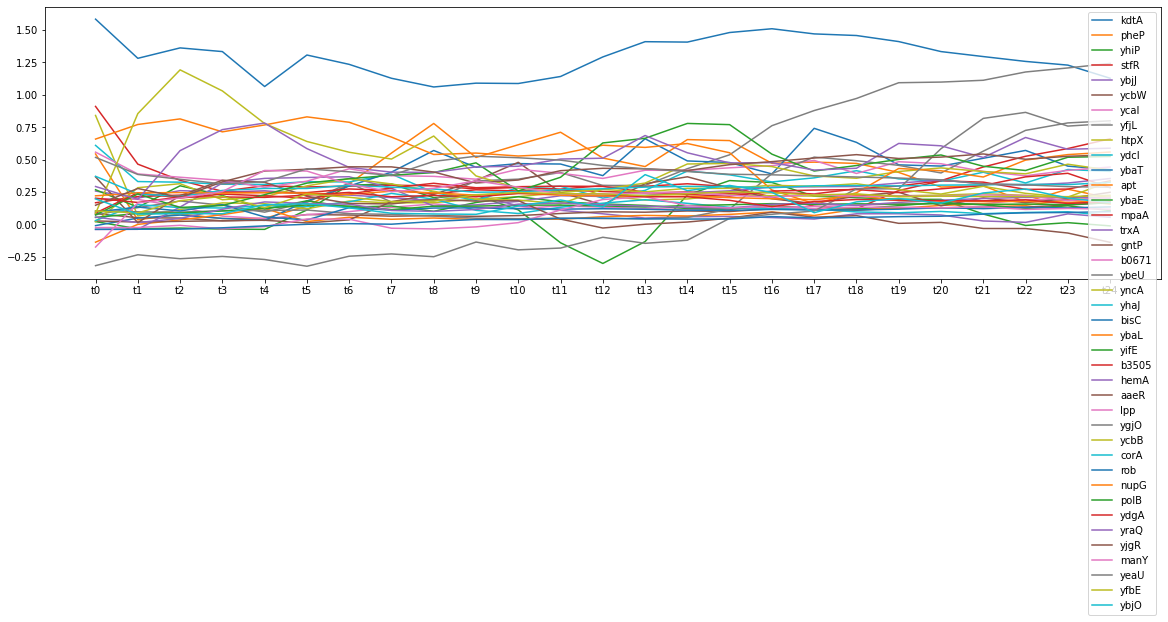

In [2]:
meangenes = pd.read_csv("/Users/zijianleowang/Downloads/Cornell/1Ongoing.Project/1000_genes_10_replicates_1_concentrations/replicates/mean.csv")
plt.figure(figsize=(20,5))
for i in range(40):
    genei = meangenes.iloc[i,3:]
    plt.plot(genei,label=meangenes.iloc[i,0])
plt.legend()

Estimated number of clusters: 2
Estimated number of noise points: 66


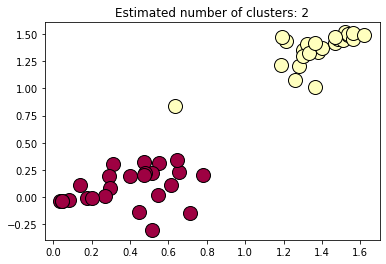

In [40]:
genes = meangenes.iloc[:,3:].T # n x d
# # genes_tsne = TSNE(perplexity=8).fit_transform(genes)
# import umap
# genes_tsne = umap.UMAP(random_state=38).fit_transform(Y)
# plt.scatter(genes_tsne[:,0],genes_tsne[:,1],edgecolors='k')
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=1.1, min_samples=10).fit(genes.T)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
# print(f"Silhouette Coefficient: {metrics.silhouette_score(genes, labels):.3f}")

unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = genes.T[class_member_mask & core_samples_mask].T
    if min(xy.shape)>=2:
        plt.plot(
            xy.iloc[:, 0],
            xy.iloc[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

    # xy = genes.T[class_member_mask & ~core_samples_mask].T
    # if min(xy.shape)>=2:
    #     plt.plot(
    #         xy.iloc[:, 0],
    #         xy.iloc[:, 1],
    #         "o",
    #         markerfacecolor=tuple(col),
    #         markeredgecolor="k",
    #         markersize=6,
    #     )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()


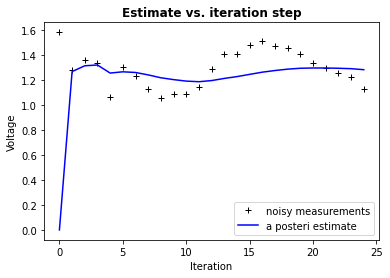

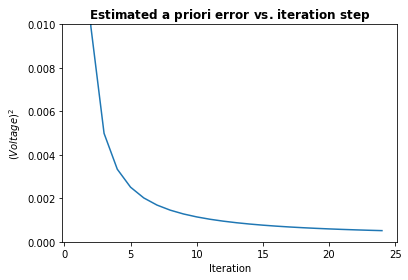

In [46]:
# test [Kalman filtering](https://scipy-cookbook.readthedocs.io/items/KalmanFiltering.html)

# intial parameters
n_iter = 25
sz = (n_iter,) # size of array
z = meangenes.iloc[0,3:].values

Q = 1e-5 # process variance

# allocate space for arrays
xhat=np.zeros(sz)      # a posteri estimate of x
P=np.zeros(sz)         # a posteri error estimate
xhatminus=np.zeros(sz) # a priori estimate of x
Pminus=np.zeros(sz)    # a priori error estimate
K=np.zeros(sz)         # gain or blending factor

R = 0.1**2 # estimate of measurement variance, change to see effect

# intial guesses
xhat[0] = 0.0
P[0] = 1.0

for k in range(1,n_iter):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q

    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]

plt.figure()
plt.plot(z,'k+',label='noisy measurements')
plt.plot(xhat,'b-',label='a posteri estimate')
# plt.axhline(x,color='g',label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Voltage')

plt.figure()
valid_iter = range(1,n_iter) # Pminus not valid at step 0
plt.plot(valid_iter,Pminus[valid_iter],label='a priori error estimate')
plt.title('Estimated $\it{\mathbf{a \ priori}}$ error vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('$(Voltage)^2$')
plt.setp(plt.gca(),'ylim',[0,.01])
plt.show()